In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, confusion_matrix, 
    classification_report, make_scorer, ConfusionMatrixDisplay, 
)


In [2]:
%load_ext watermark


In [3]:
%watermark -vp numpy,pandas,sklearn,feature_engine


Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.8.0

numpy         : 1.23.3
pandas        : 1.5.0
sklearn       : 1.2.2
feature_engine: 1.6.0



## Data

Simulamos un dataset de clasificación con sklearn.

In [4]:
X, y = make_classification(
    n_samples=5_000, n_features=10, n_informative=2, n_redundant=8, n_classes=2,
	n_clusters_per_class=2, weights=[0.6, 0.4], flip_y=0.1, class_sep=0.8, 
    random_state=42)
# features informativos: afectan a la variable rpta 
# features redundantes: combinaciones lineales aleatorias de los informativos
# resto: ruido


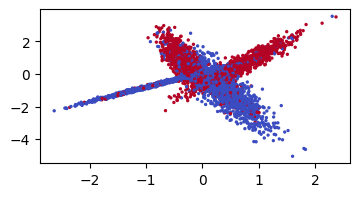

In [5]:
# plot features and target
plt.figure(figsize=(4, 2))
plt.scatter(X[:, 0], X[:, 1], c=y, s=2, cmap='coolwarm')
plt.show()


## Ajuste de hiperparámetros

Buscamos un _buen_ Random Forest con grid search y K-fold Cross-Validation. Asumimos que el set de test ya está separado!

Para simplificar, solo vamos a hacer la búsqueda sobre pocos valores de un solo hiperparámetro.

In [6]:
RandomForestClassifier().get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [7]:
param_grid = {
    'min_samples_leaf': [5, 10, 50, 100, 1000],
    # 'max_features': [2, 4, 6, 8, 10],
}


In [8]:
# Alternativa más general:
# 
# param_grid = [
#   {
#     'clf': [LogisticRegression(max_iter=1000)],
#     'clf__l1': [...]
# },
#   {
#     'clf': [RandomForest()],
#     'clf__min_samples_leaf': [5, 10, 50, 100, 1000]
# },
# ]        


Definimos una matriz de costos arbitraria que suponemos puede ser de interés para el problema.

In [9]:
# filas: y, cols: y_pred
cost_matrix = np.array([
    [0, 1], # TRUE NEGATIVE, FALSE POSITIVE
    [5, 0], # FALSE NEGATIVE, TRUE POSITIVE
]) 

def gain_function(
    y: np.ndarray, y_pred: np.ndarray, cost_matrix: np.ndarray
) -> float:
    """Función de ganancia (costo negativo por obs.)"""
    return -np.sum(cost_matrix[y, y_pred]) / len(y)


In [10]:
# ejemplo de uso:
print(
    gain_function([1,1,1], [0,0,0], cost_matrix), # real:1 , pred:0
    gain_function([0,0,0], [1,1,1], cost_matrix), # real:0 , pred:1
)


-5.0 -1.0


Definimos las métricas con las que queremos evaluar los modelos en los sets de validación. 

En principio nos va a interesar un modelo que sea bueno "globalmente" i.e. que tenga buena capacidad de discriminar entre 0s y 1s.

También guardamos el "gain" (costo negativo) para hacer comparaciones más adelante.

In [11]:
scoring = {
    "AUC": "roc_auc",
    "Gain": make_scorer(gain_function, cost_matrix=cost_matrix)
}


In [12]:
# modelo base sobre el cual vamos a probar HPs:
clf = RandomForestClassifier(n_estimators=200, max_features="sqrt", random_state=0)

# stratified k-fold conserva la proporción de clases en cada fold:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(clf, param_grid, cv=skf, scoring=scoring, refit="AUC", verbose=3)

# run grid search with CV
_ = grid_search.fit(X, y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[CV 1/5] END min_samples_leaf=5; AUC: (test=0.889) Gain: (test=-0.476) total time=   5.3s
[CV 2/5] END min_samples_leaf=5; AUC: (test=0.876) Gain: (test=-0.437) total time=   3.7s
[CV 3/5] END min_samples_leaf=5; AUC: (test=0.892) Gain: (test=-0.436) total time=   3.6s
[CV 4/5] END min_samples_leaf=5; AUC: (test=0.873) Gain: (test=-0.523) total time=   3.6s
[CV 5/5] END min_samples_leaf=5; AUC: (test=0.896) Gain: (test=-0.529) total time=   3.4s
[CV 1/5] END min_samples_leaf=10; AUC: (test=0.897) Gain: (test=-0.454) total time=   3.4s
[CV 2/5] END min_samples_leaf=10; AUC: (test=0.876) Gain: (test=-0.475) total time=   3.4s
[CV 3/5] END min_samples_leaf=10; AUC: (test=0.896) Gain: (test=-0.461) total time=   3.4s
[CV 4/5] END min_samples_leaf=10; AUC: (test=0.877) Gain: (test=-0.524) total time=   3.4s
[CV 5/5] END min_samples_leaf=10; AUC: (test=0.901) Gain: (test=-0.506) total time=   3.4s
[CV 1/5] END min_samples_leaf=50; AUC: (test=0.904) Gain: (test=-0.490) total time=   2.2s
[CV 

Analizamos los resultados y conservamos el mejor modelo encontrado.

In [13]:
print(grid_search.best_params_)


{'min_samples_leaf': 50}


In [14]:
# results to dataframe
df_cv = pd.DataFrame(grid_search.cv_results_)


In [15]:
df_cv[["params","mean_test_AUC", "mean_test_Gain"]]


,params,mean_test_AUC,mean_test_Gain
0,{'min_samples_leaf': 5},0.885434,-0.4802
1,{'min_samples_leaf': 10},0.889456,-0.4840
2,{'min_samples_leaf': 50},0.894296,-0.5278
3,{'min_samples_leaf': 100},0.889886,-0.6100
4,{'min_samples_leaf': 1000},0.797436,-0.6358


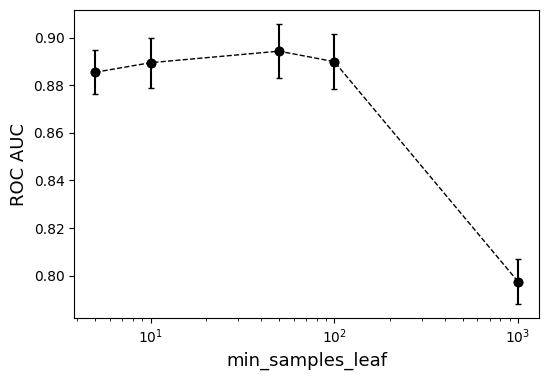

In [16]:
# plot ROC auc as function of min_samples_leaf with x log scale and error bars
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(
    df_cv['param_min_samples_leaf'], df_cv['mean_test_AUC'],
    marker='o', linestyle='--', linewidth=1, color='black')
ax.errorbar(
    df_cv['param_min_samples_leaf'], df_cv['mean_test_AUC'],
    yerr=df_cv['std_test_AUC'], fmt='o', color='black', capsize=2)
ax.set_xscale('log')
plt.xlabel('min_samples_leaf', fontsize=13)
plt.ylabel('ROC AUC', fontsize=13)
plt.show()

# el plot es muy interpretable porque movimos un solo hiperparámetro


In [17]:
print("So far:")
print(f"Best Gain = {df_cv['mean_test_Gain'].max():.1f}")
print(f"Best AUC = {df_cv['mean_test_AUC'].max():.3f}")


So far:
Best Gain = -0.5
Best AUC = 0.894


## Punto de corte

Para el mejor modelo según AUC, buscamos los puntos de corte que maximizan f1_score, accuracy y el Gain (en la práctica elegimos una sola métrica).

Usamos los mismos folds que usamos para optimizar los hiperparámetros.

In [18]:
def to_labels(probas, threshold):
	return (probas >= threshold).astype('int')


In [19]:
clf = grid_search.best_estimator_
# grilla de umbrales -- lo tratamos como un hipermarametro más
thresholds = np.linspace(0, 1, 500+1) 


In [20]:
results = []
for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X[val_index], X[val_index]
    y_train, y_val = y[val_index], y[val_index]
    clf.fit(X_train, y_train)
    scores_val = clf.predict_proba(X_val)[:, 1]
    for threshold in thresholds:
        y_pred = to_labels(scores_val, threshold)
        result = {
            'f1': f1_score(y_val, y_pred),
            'accuracy': accuracy_score(y_val, y_pred),
            'gain': gain_function(y_val, y_pred, cost_matrix),
            'precision': precision_score(y_val, y_pred, zero_division=0),
            'threshold': threshold,
            'fold': i,
        }
        results.append(result)


**NOTA** sobre ajustar el umbral en el set de validación:

Estamos tuneando el umbral en los mismos datos sobre los cuales estamos evaluando. Esto es análogo a entrenar y evaluar sobre los mismos datos. Puede llevar a sobreestimar el rendimiento del modelo. Como regla general, si "tuneo" algo, me tengo que fijar en datos nuevos si funciona.

Tunear el umbral en los datos de entrenamiento tampoco es correcto porque esos _scores_ pueden ser poco representativos de los puntajes en datos nuevos. 

Lo más correcto sería separar un set adicional para tunear el umbral. Por ejemplo, partiendo en train + train-threshold + val (hay opciones más complicadas).

Dado que asumimos que tenemos un set de test independiente para evaluar el rendimiento final, no nos vamos a preocupar mucho por esto -- si el rendimiento en validación es optimista, nos vamos a enterar eventualmente! No vamos a reportar el rendimiento en validación como si fuera el rendimiento final. Solo lo usamos para elegir el umbral.


In [21]:
# convert results to a DataFrame
df_threshold = pd.DataFrame(results)
# get mean and standard error by threshold
df_threshold = df_threshold.groupby('threshold').agg(
    {'f1': ['mean', 'std'], 'accuracy': ['mean', 'std'], 'gain': ['mean', 'std'],
    'precision': ['mean', 'std']})
# flatten column names
df_threshold.columns = ['_'.join(col).strip() for col in df_threshold.columns.values]
df_threshold.reset_index(inplace=True)


In [22]:
df_threshold.sort_values('gain_mean', ascending=False).head(10)


,threshold,f1_mean,f1_std,accuracy_mean,accuracy_std,gain_mean,gain_std,precision_mean,precision_std
116,0.232,0.757463,0.008503,0.7508,0.011145,-0.3468,0.014906,0.633927,0.011843
113,0.226,0.756326,0.008484,0.7490,0.011136,-0.3470,0.015232,0.631902,0.011769
132,0.264,0.764155,0.003447,0.7616,0.004278,-0.3472,0.007530,0.646499,0.005057
131,0.262,0.763646,0.003380,0.7608,0.004382,-0.3472,0.006099,0.645542,0.005258
117,0.234,0.757856,0.007952,0.7516,0.010383,-0.3476,0.013777,0.634907,0.011072
115,0.230,0.756877,0.008545,0.7500,0.011314,-0.3476,0.014381,0.633115,0.012121
129,0.258,0.762388,0.004206,0.7590,0.005292,-0.3482,0.008438,0.643518,0.005982
118,0.236,0.757910,0.008048,0.7518,0.010474,-0.3482,0.013405,0.635201,0.011125
112,0.224,0.755449,0.008494,0.7478,0.011300,-0.3482,0.014618,0.630687,0.012013
114,0.228,0.756292,0.008716,0.7492,0.011606,-0.3484,0.014433,0.632302,0.012392


In [23]:
def plot_performance_by_threshold(df_results, metric_name):
    fig, ax = plt.subplots(figsize=(6,2))
    x = df_results['threshold']
    y = df_results[metric_name + '_mean']
    std = df_results[metric_name + '_std']
    ax.plot(x, y, marker=None, linestyle='--', linewidth=1, color='black')
    ax.fill_between(x, y - std, y + std, color='black', alpha=0.2)
    best_threshold = x.iloc[np.argmax(y)]
    best_value = y.max()
    plt.axvline(x=best_threshold, linestyle='--', color='red')
    plt.title(f"Threshold={best_threshold:.3f}, value={best_value:.3f}")
    plt.xlabel('threshold', fontsize=13)
    plt.ylabel(metric_name, fontsize=13)


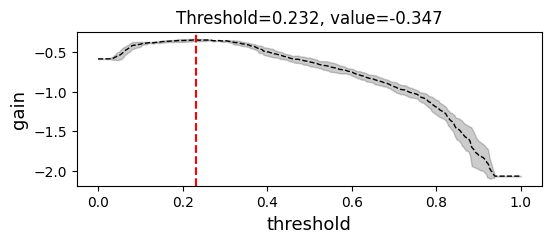

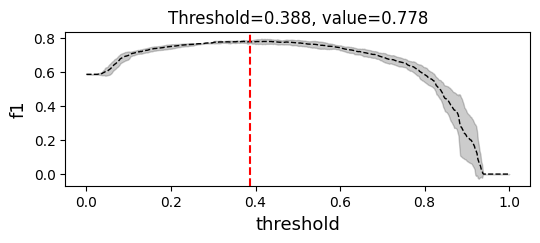

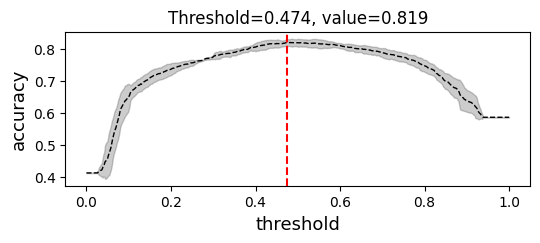

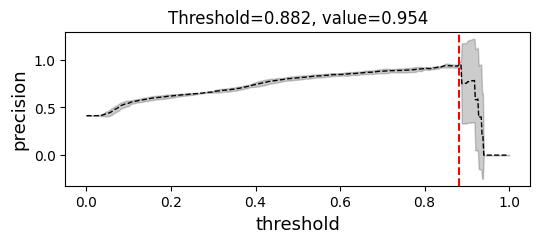

In [24]:
# vemos que el umbral optimo depende de la metrica que elijamos
plot_performance_by_threshold(df_threshold, 'gain')
plt.show()

plot_performance_by_threshold(df_threshold, 'f1')
plt.show()

plot_performance_by_threshold(df_threshold, 'accuracy')
plt.show()

plot_performance_by_threshold(df_threshold, 'precision')
plt.show()


Visualizamos la matriz de confusion y métricas de clasificación para el modelo y threshold con mejor gain.  

Lo hacemos sobre todos los datos. En un caso real lo podríamos hacer sobre el set de test.

In [25]:
clf = grid_search.best_estimator_
threshold = df_threshold['threshold'].iloc[df_threshold['gain_mean'].idxmax()]


In [26]:
y_pred_probas = clf.predict_proba(X)[:, 1]
y_pred = to_labels(y_pred_probas, threshold)


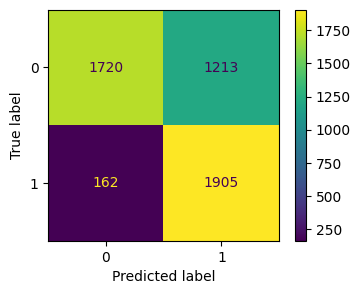

In [37]:
# plot confusion matrix
cm = confusion_matrix(y, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
fig = plt.gcf()
fig.set_size_inches(4, 3)
plt.show()


In [28]:
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.59      0.71      2933
           1       0.61      0.92      0.73      2067

    accuracy                           0.73      5000
   macro avg       0.76      0.75      0.72      5000
weighted avg       0.79      0.72      0.72      5000



## Otras herramientas de evaluación

### Hosmer-Lemeshow Plot

In [29]:
df_pred = pd.DataFrame({
    'y': y,
    'y_pred': y_pred,
    'y_pred_probas': y_pred_probas
})


In [30]:
def hosmer_lemeshow_plot(df, bins=10, type="uniform"):
    # cut proba in equal length bins
    if type == "uniform":
        df['bin'] = pd.cut(df_pred['y_pred_probas'], bins=bins, labels=False)
    # cut proba in equal n bins
    elif type == "quantile":
        df['bin'] = pd.qcut(df_pred['y_pred_probas'], q=bins, labels=False)
    # mean score by bin
    df_bin = df.groupby('bin').agg(
        score=("y_pred_probas", "mean"), 
        target=("y", "mean"),
        n=("y", "count"))
    # scatter plot with point size according to count
    plt.scatter(df_bin['score'], df_bin['target'], s=df_bin['n'], alpha=0.5)
    # add text with count for each bin
    for i, row in df_bin.iterrows():
        plt.text(row['score'], row['target'], int(row['n']), fontsize=10, 
        color='black', va="bottom", ha="right")
    # add diagonal line
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('score')
    plt.ylabel('target')


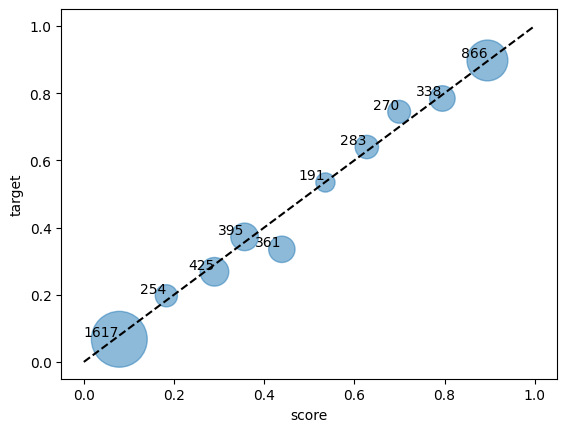

In [31]:
hosmer_lemeshow_plot(df_pred, bins=10, type="uniform")
plt.show()


### Violin plot

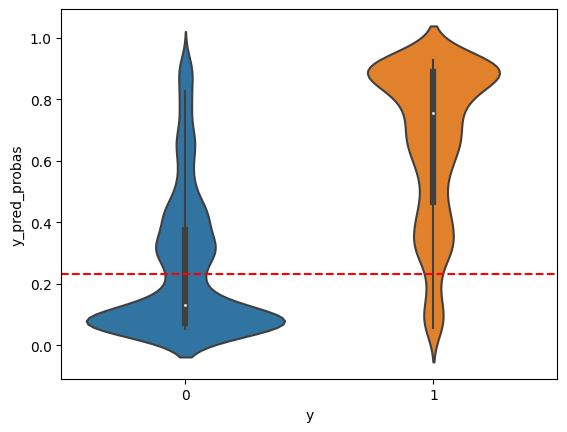

In [32]:
# violin plot with a horizontal line for the best threshold
ax = sns.violinplot(x="y", y="y_pred_probas", data=df_pred)
ax.axhline(y=threshold, color='red', linestyle='--')
plt.show()
